In [18]:
%pylab inline

import uuid
import random
import string
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Populating the interactive namespace from numpy and matplotlib


/Users/ripado/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [16]:
songs = pd.read_json('songs.json')
songs['epoch'] = songs.year.map(lambda y: int(y/10)*10)
songs.head()

,_id,album,artist,cover,genre,source,title,year,epoch
0,8a874d47-333a-4ff4-a351-c2f846190484,Steppenwolf,Steppenwolf,covers/steppenwolf_steppenwolf_cover.jpg,rock,musicfiles/01-Sookie_Sookie.mp3,Sookie Sookie,1968,1960
1,ad013f7e-4d46-4245-bf96-3f22afd35498,Steppenwolf,Steppenwolf,covers/steppenwolf_steppenwolf_cover.jpg,rock,musicfiles/02-Everybody's_Next_One.mp3,Everybody's Next One,1968,1960
2,dabd612c-b3b9-4c3e-adcc-612592b83698,Steppenwolf,Steppenwolf,covers/steppenwolf_steppenwolf_cover.jpg,rock,musicfiles/03-Berry_Rides_Again.mp3,Berry Rides Again,1968,1960
3,e8b434ac-b993-488f-8c0f-08aeb12f521b,Steppenwolf,Steppenwolf,covers/steppenwolf_steppenwolf_cover.jpg,rock,musicfiles/04-Hoochie_Coochie_Man.mp3,Hoochie Coochie Man,1968,1960
4,108393e1-2ad7-4f67-bf15-38e70f9fc885,Steppenwolf,Steppenwolf,covers/steppenwolf_steppenwolf_cover.jpg,rock,musicfiles/05-Born_To_Be_Wild.mp3,Born To Be Wild,1968,1960


In [2]:
def catalog_viz(songs):
    
    print('TOTALS:')
    print('- songs:   {} (approx {:.1f}h)'.format(len(songs), 3 * len(songs) / 60))
    un = songs['artist'].unique()
    print('- artists: {} (approx {:.1f}h)'.format(len(un), 3 * len(un) /60))
    
    grouped = songs.groupby(['epoch', 'genre'])
    data = grouped.apply(lambda x: len(x)).to_frame('songs')
    data['artists'] = grouped.apply(lambda x: x.artist.unique().size)
    data.reset_index(inplace=True)
    
    gridspec = {}
    fig, axs = plt.subplots(figsize=(10,5), nrows=2, ncols=5, gridspec_kw=gridspec, sharex=True)
    targets = zip(data.epoch.unique(), axs.flatten())
    for i, (key, ax) in enumerate(targets):
        data[data['epoch'] == key][['genre', 'songs', 'artists']].plot.bar(x='genre',ax=ax, legend=False)
        ax.set_title(key)
    
    axs[0,4].legend(bbox_to_anchor=(1, 1.2), loc='lower right', borderaxespad=0.)
    plt.tight_layout()
    plt.show()
    
    grouped = songs.groupby('genre')
    groups = grouped.groups.keys()
    fig, axs = plt.subplots(figsize=(12,3), nrows=1, ncols=len(groups))
    for i, g in enumerate(groups):
        vs = grouped.get_group(g)['artist'].value_counts()
        grouped.get_group(g)['artist'].value_counts().hist(ax=axs[i], bins=vs.max())
        axs[i].set_title(g)

    plt.show()

def catalog_stats(songs):
    gcounts = songs.groupby('genre').apply(lambda x: len(x))
    ret = {
        'total_songs': len(songs),
        'total_artists': len(songs['artist'].unique()),
        'songs_per_genre': gcounts.to_dict(),
        'avg_songs_per_genre': gcounts.mean(),
        'avg_songs_per_artist': songs.groupby('artist').apply(lambda x: len(x)).mean()
    }
    
    return ret

In [38]:
catalog_stats(songs)
# catalog_viz(songs)

{'avg_songs_per_artist': 1.6921182266009853,
 'avg_songs_per_genre': 229.0,
 'songs_per_genre': {'jazz': 114, 'rnb-hiphop': 206, 'rock': 367},
 'total_artists': 406,
 'total_songs': 687}

In [3]:
def random_string(n=20):
    return ''.join(random.choice(string.ascii_letters + string.digits) for _ in range(n))

def generate_catalog(params):
    
    songs = []

    
    for e in range(10):
        epoch = 1920 + e*10        
        
        for g in params.keys():
            # Compute number of songs per epoch
            estimate = math.ceil(params[g]['songs']/10)
                        
            # Gen artists
            artists = [random_string(10) for i in range(math.ceil(params[g]['songs']/params[g]['spa']))]
            a = 0
            for i in range(round(params[g]['songs']/10)):
                if a >= len(artists): a=0
                    
                songs.append([
                    uuid.uuid4(),
                    random_string(),  # title
                    artists[a],  # artist
                    None,             # cover
                    g,                # genre
                    None,             # source
                    epoch + random.randint(0,9),
                    epoch
                ])
                
                a += 1
                
    return pd.DataFrame(songs, columns=['_id', 'title', 'artist', 'cover', 'genre', 'source', 'year', 'epoch'])


catalog size 90
TOTALS:
- songs:   90 (approx 4.5h)
- artists: 90 (approx 4.5h)


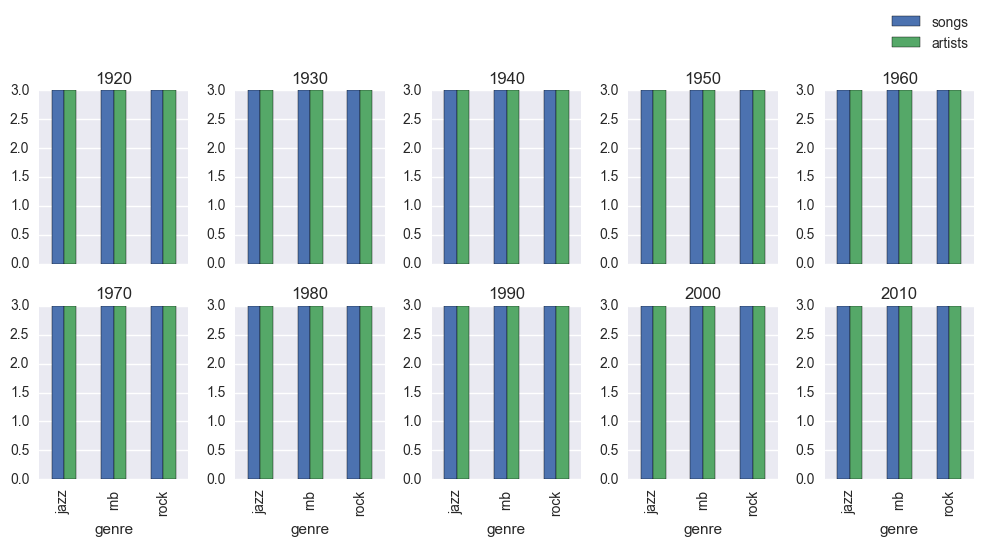

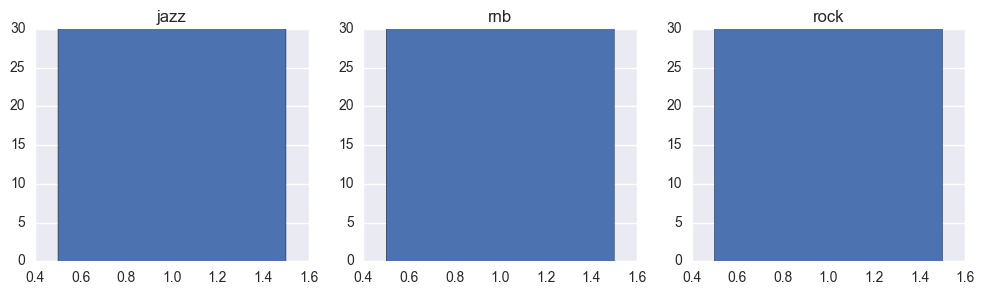

{'avg_songs_per_artist': 1.0,
 'avg_songs_per_genre': 30.0,
 'songs_per_genre': {'jazz': 30, 'rnb': 30, 'rock': 30},
 'total_artists': 90,
 'total_songs': 90}

In [5]:
params = {
    'rock': {'songs': 34, 'spa': 1},
    'jazz': {'songs': 33, 'spa': 1},
    'rnb': {'songs': 33, 'spa': 1},
}

cat = generate_catalog(params)
# catalog_viz(cat)

print('catalog size', len(cat))
catalog_viz(cat)
catalog_stats(cat)

In [6]:
def filter_genre_balance(candidates, played, settings):
    genre = settings['genres'][random.randint(0, len(settings['genres']) - 1)]
    return [c for c in candidates if c[4] == genre]

def filter_epoch_balance(candidates, played, settings):
    epoch = settings['epochs'][random.randint(0, len(settings['epochs']) - 1)]
    return [c for c in candidates if c[7] == epoch]

def filter_artist_norepeat(candidates, played, settings):
    playedStart = max(len(played) - settings['artist_norepeat'], 0)
    playedArtists = [s[2] for s in played[playedStart:]]
    return [c for c in candidates if c[2] not in playedArtists]

def filter_song_norepeat(candidates, played, settings):
    playedStart = max(len(played) - settings['song_norepeat'], 0)
    playedIds = [s[0] for s in played[playedStart:]]
    return [c for c in candidates if c[0] not in playedIds]

def playlist_gen(songs, params):
    
    def apply_filter(filter_func, songs, played, filter_params):
        filtered_songs = filter_func(songs, played, filter_params)
        if not filtered_songs:
            # print("WARNING: Ignoring filter '{}'.".format(filter_func.__name__))
            return [songs, True]
        return [filtered_songs, False]
    
    ret = []
    hard_filters = [
        filter_song_norepeat,
        filter_artist_norepeat
    ]
    soft_filters = [
        filter_genre_balance,
        filter_epoch_balance
    ]
    errs = []
    hard_err = False
    for i in range(params['step_size']):
        candidates = songs
        err = False
        
        for song_filter in hard_filters:
            [candidates, filterErr] = apply_filter(song_filter, candidates, ret, params)
            err = err or filterErr
        
        if err: 
            hard_err = True
            break
        
        for song_filter in soft_filters:
            [candidates, filterErr] = apply_filter(song_filter, candidates, ret, params)
            err = err or filterErr
        
        v = random.randint(0, len(candidates) - 1)
        errs.append(err)
        ret.append(candidates[v])    
            
    return [ret, errs]

def generate_playlist(catalog, params):
    [playlist, errs] = playlist_gen(catalog.values.tolist(), params)
    songs = pd.DataFrame(playlist, columns=['_id', 'title', 'artist', 'cover', 'genre', 'source', 'year', 'epoch'])
    songs['errors'] = errs
    return [songs, len(songs) != params['step_size']]

## GenSIM

In [166]:
# Rules

# 1. Can't repeat song for at least 5 hours
song_norepeat = 5 * 60 / 3
print('song_norepeat:   {:.0f} songs (5h)'.format(song_norepeat))


# 2. Can't repeat artist for at least 3 hours
artist_norepeat = 3 * 60 / 3
print('artist_norepeat:  {:.0f} songs (3h)'.format(artist_norepeat))


song_norepeat:   100 songs (5h)
artist_norepeat:  60 songs (3h)


In [19]:
def bscore(songs, err):
    if err: return np.NaN
    
    grouped = songs.groupby('genre')
    n = len(songs)
    n_genre_song = round(n/grouped.ngroups)
    correction = abs(n - n_genre_song * grouped.ngroups)

    err = grouped.apply(lambda x: abs(len(x) - n_genre_song)).sum()
    return (err - correction)/(2*n)

"""
params = {
    'rock': {
        'songs':   120,
        'spa':     1.3
    },
    'jazz': {
        'songs': 100,
        'spa':     2.5
    },
    'rnb':  {
        'songs': 80,
        'spa':     1
    }
}

cat = generate_catalog(params)
print(bscore(cat, False))
""";

In [35]:
def simulate_playlist(catalog, pl_params, times):
    """ Generate and evaluate a playlist, times times. Store scores in array"""
    scores = []
    errs = []
    for i in range(times):
        [pl, err] = generate_playlist(catalog, pl_params)
        scores.append(bscore(pl, err))
        errs.append(err)
    
    return [scores, errs]

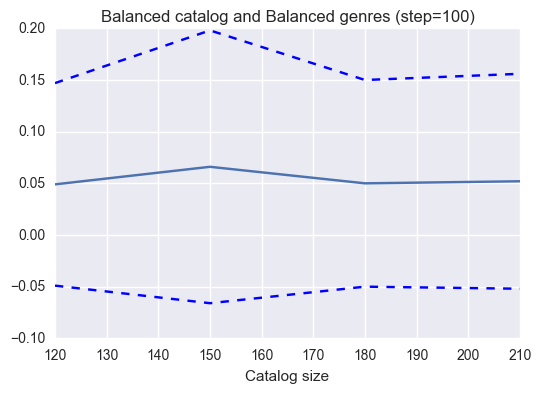

In [37]:
cat_min = 100
cat_max = 200
cat_step = 30
times = 10

pl_params = {
    'step_size': 100,
    'song_norepeat': 100,  # 5h
    'artist_norepeat': 60, # 3h
    'genres': ['jazz', 'rock', 'rnb'],
    'epochs': [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]  
}

sizes = []
score_avgs = []
score_stds = []
for cat_size in range(cat_min, cat_max + cat_step, cat_step):    
    spg = round(cat_size/3)
    params = {
        'rock': {'songs': spg, 'spa': 1},
        'jazz': {'songs': spg, 'spa': 1},
        'rnb': {'songs': spg, 'spa': 1},
    }
    
    cat = generate_catalog(params)
    stats = catalog_stats(cat)
    if stats['total_songs'] in sizes: continue
        
    # print("Simulating: {}".format(cat_size))
    [scores, err] = simulate_playlist(cat, pl_params, times)
    
    stats = catalog_stats(cat)
    sizes.append(stats['total_songs'])
    
    score_avgs.append(np.mean(scores))
    score_stds.append(np.std(scores))

plt.plot(sizes, score_avgs)
plt.plot(sizes, np.subtract(score_avgs, np.multiply(2, score_avgs)), 'b--')
plt.plot(sizes, np.add(score_avgs, np.multiply(2, score_avgs)), 'b--')
plt.title("Balanced catalog and Balanced genres (step=100)")
plt.xlabel("Catalog size")

plt.show()
#print(sizes)
#print(score_avgs)

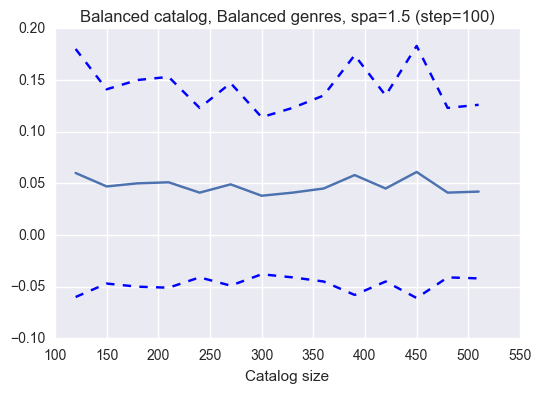

[90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510]
[nan, 0.059999999999999998, 0.047, 0.050000000000000003, 0.051000000000000004, 0.040999999999999995, 0.049000000000000002, 0.037999999999999992, 0.040999999999999995, 0.044999999999999998, 0.05800000000000001, 0.044999999999999998, 0.061000000000000013, 0.041000000000000002, 0.042000000000000003]


In [40]:
cat_min = 100
cat_max = 500
cat_step = 30
times = 10

pl_params = {
    'step_size': 100,
    'song_norepeat': 100,  # 5h
    'artist_norepeat': 60, # 3h
    'genres': ['jazz', 'rock', 'rnb'],
    'epochs': [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]  
}

sizes = []
score_avgs = []
score_stds = []
for cat_size in range(cat_min, cat_max + cat_step, cat_step):    
    spg = round(cat_size/3)
    params = {
        'rock': {'songs': spg, 'spa': 3},
        'jazz': {'songs': spg, 'spa': 3},
        'rnb': {'songs': spg, 'spa': 3},
    }
    
    cat = generate_catalog(params)
    stats = catalog_stats(cat)
    if stats['total_songs'] in sizes: continue
        
    # print("Simulating: {}".format(cat_size))
    [scores, err] = simulate_playlist(cat, pl_params, times)
    
    stats = catalog_stats(cat)
    sizes.append(stats['total_songs'])
    
    score_avgs.append(np.mean(scores))
    score_stds.append(np.std(scores))

plt.plot(sizes, score_avgs)
plt.plot(sizes, np.subtract(score_avgs, np.multiply(2, score_avgs)), 'b--')
plt.plot(sizes, np.add(score_avgs, np.multiply(2, score_avgs)), 'b--')
plt.title("Balanced catalog, Balanced genres, spa=3 (step=100)")
plt.xlabel("Catalog size")

plt.show()
print(sizes)
print(score_avgs)


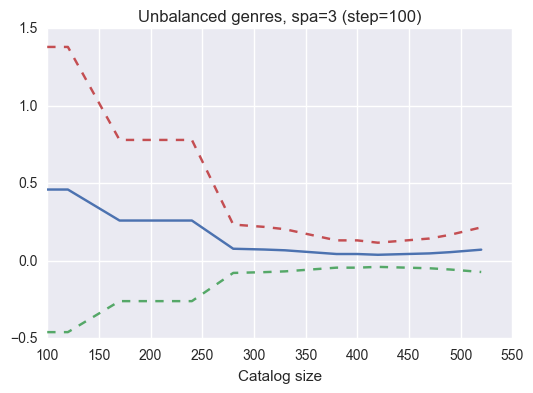

[100, 120, 170, 190, 220, 240, 280, 310, 330, 380, 400, 420, 470, 490, 520]
[0.46000000000000008, 0.46000000000000008, 0.25999999999999995, 0.25999999999999995, 0.25999999999999995, 0.25999999999999995, 0.077999999999999986, 0.073000000000000009, 0.068000000000000019, 0.044000000000000004, 0.043999999999999997, 0.039, 0.047999999999999994, 0.056000000000000008, 0.072000000000000022]


In [47]:
cat_min = 100
cat_max = 500
cat_step = 30
times = 10

pl_params = {
    'step_size': 100,
    'song_norepeat': 100,  # 5h
    'artist_norepeat': 60, # 3h
    'genres': ['jazz', 'rock', 'rnb'],
    'epochs': [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]  
}

sizes = []
score_avgs = []
score_stds = []
for cat_size in range(cat_min, cat_max + cat_step, cat_step):    
    params = {
        'rock': {'songs': round(cat_size * 0.1), 'spa': 3},
        'jazz': {'songs': round(cat_size * 0.1), 'spa': 3},
        'rnb': {'songs': round(cat_size * 0.8), 'spa': 3},
    }
    
    cat = generate_catalog(params)
    stats = catalog_stats(cat)
    if stats['total_songs'] in sizes: continue
        
    # print("Simulating: {}".format(cat_size))
    [scores, err] = simulate_playlist(cat, pl_params, times)
    
    stats = catalog_stats(cat)
    sizes.append(stats['total_songs'])
    
    score_avgs.append(np.mean(scores))
    score_stds.append(np.std(scores))

plt.plot(sizes, score_avgs)
plt.plot(sizes, np.subtract(score_avgs, np.multiply(2, score_avgs)), '--')
plt.plot(sizes, np.add(score_avgs, np.multiply(2, score_avgs)), '--')
plt.title("Unbalanced genres, spa=3 (step=100)")
plt.xlabel("Catalog size")

plt.show()
print(sizes)
print(score_avgs)

# Score Vs Cat size



- for a balanced catalog and spa=1 - 5
- for unbalanced catalog


